### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [15]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [16]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [17]:
atn

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF,Total
ADNI,1209,1210,1023,1017
AIBL,57,57,57,57
ARWIBO,239,257,271,217
DOD-ADNI,113,116,117,113
EDSD,90,89,86,86
EMIF,1019,1020,1025,1014
EPAD,1717,1764,1297,1237
JADNI,197,197,197,197
NACC,509,537,572,506
PREVENT-AD,133,133,133,133


In [18]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [19]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
diag

,AD,CU,MCI
ADNI,220,266,531
AIBL,0,0,1
ARWIBO,53,1,37
DOD-ADNI,0,100,13
EDSD,1,0,85
EMIF,197,193,521
EPAD,9,1227,0
JADNI,55,54,88
NACC,154,237,40
PREVENT-AD,0,133,0


### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [21]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [22]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [23]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [24]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [25]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

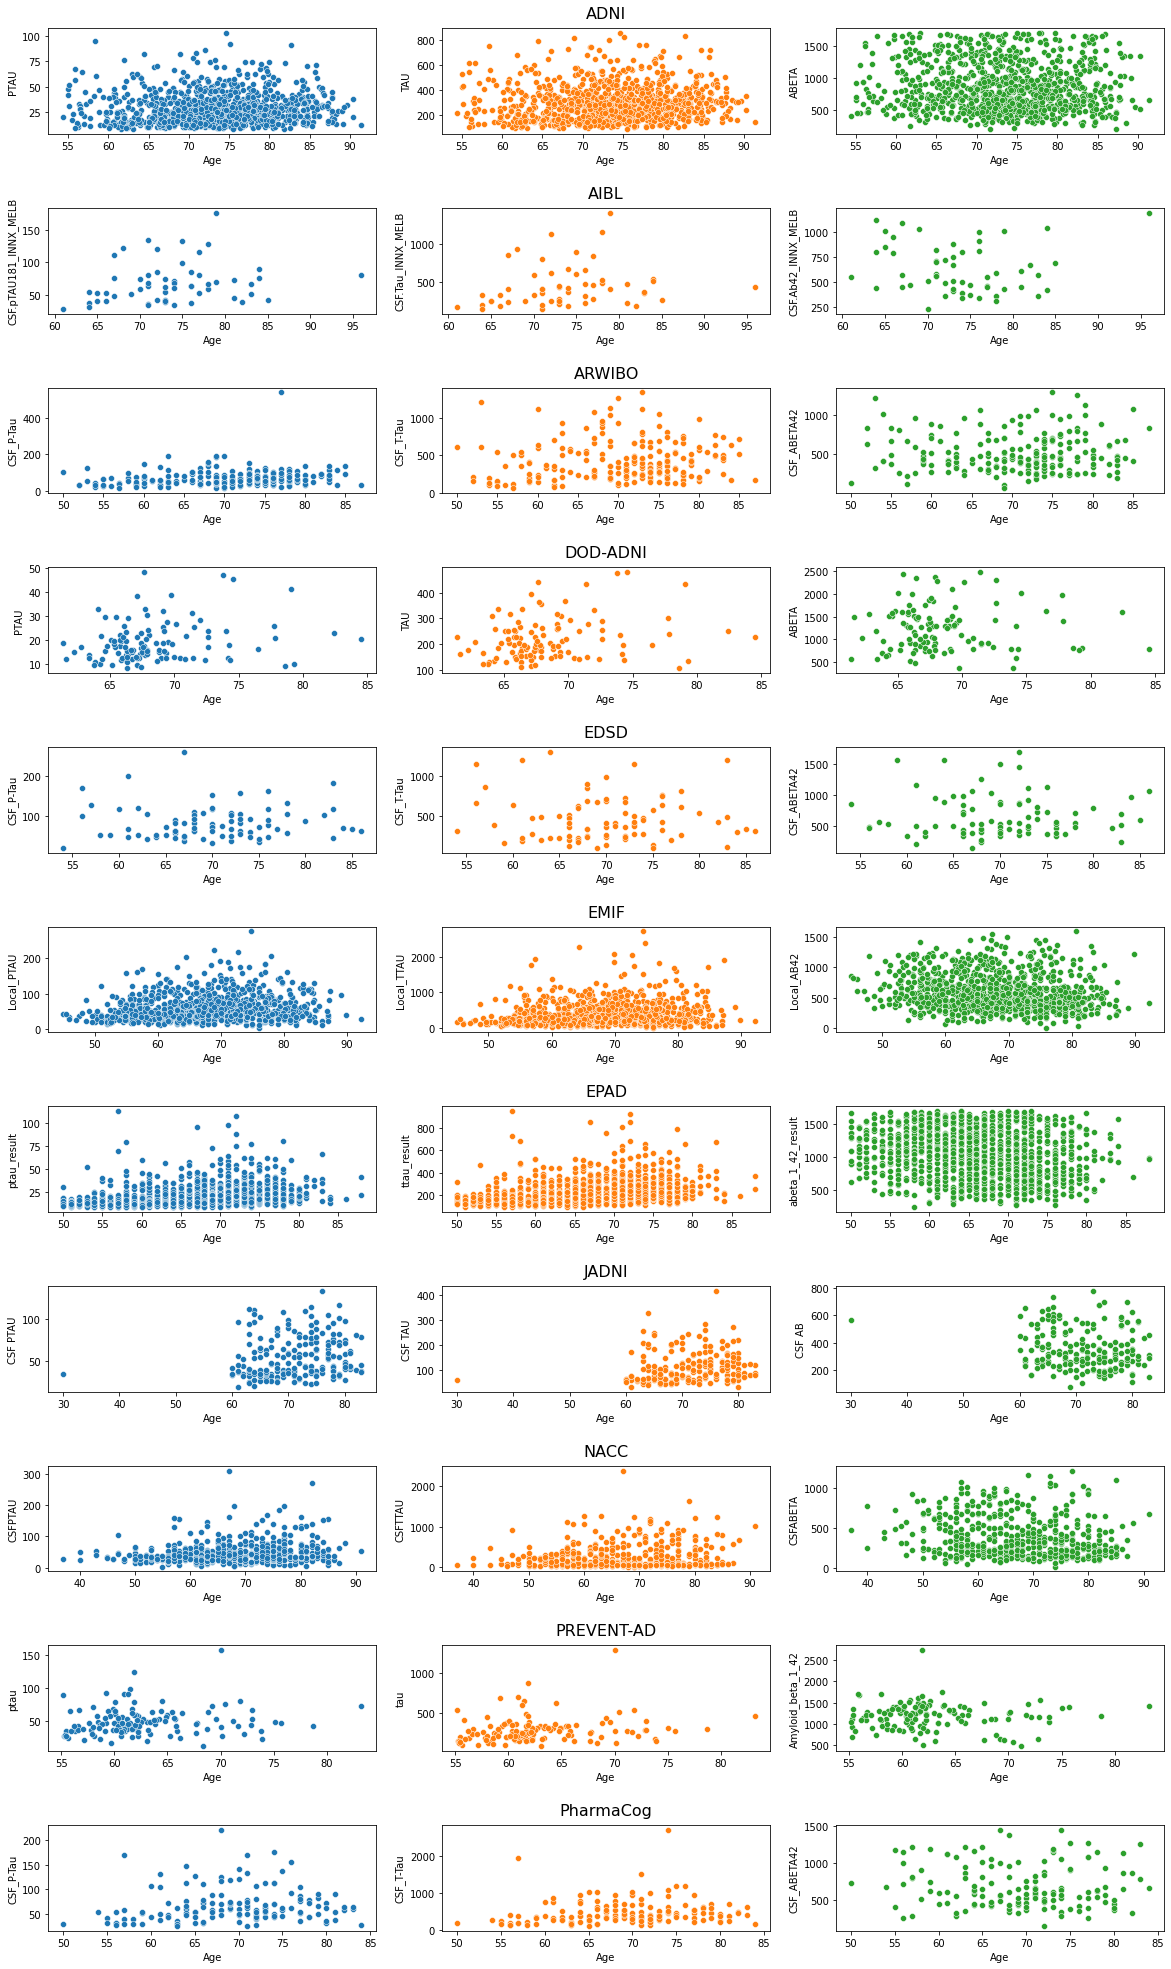

In [26]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [27]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3][i].to_list()
    cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
    cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
#     for col in ['A', 'T', 'N']:
#         cohorts_csf[i][col]=np.nan

# Density-based spatial clustering of applications with noise (DBSCAN)

### Scale CSF Features

In [28]:
# scale each feature and write it as a new column in the respective dataframe
# name the new columns with a suffix "_scaled"
for cohort in cohorts_csf:
    
    for i in cohorts_csf[cohort][cohorts_csf[cohort].columns[:3].to_list() + ['Age']]:    
        cohorts_csf[cohort][i + '_scaled'] = MinMaxScaler().fit_transform(X=cohorts_csf[cohort][[i]])

In [29]:
for i in cohorts_csf:
    if len(cohorts_csf[i][cohorts_csf[i].columns[1]]) != len(cohorts_csf[i]['Age_scaled'].dropna()):
        print(i)

### DBSCAN Training

In [30]:
hypersss = dict()
scoresss = dict()

for i in cohorts_csf:
    
    
    # Create empty dictionary for storing hyperparameters (epsilon and min_samples)
    hyper = dict()

    # Create empty dictionary for storing Silhouette scores
    scores = dict()

    # Define ranges to explore
    eps_range = np.arange(0.01, 0.5, 0.02) # radius 
#     min_points = np.arange(2, len(cohorts_csf[i].index)*0.5, 3) # minimum number of points/samples in a neighborhood
    min_points = np.arange(2, 10, 1) # minimum number of points/samples in a neighborhood


    for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][i].to_list()]:
        sco = list()
        silh = list()

        for e in eps_range:

            for n in min_points:
                # Set the model and its parameters
                model = DBSCAN(eps=e, min_samples=n)
                # Fit the model 
                clm = model.fit(cohorts_csf[i][[biom, 'Age_scaled']])
                
                # make a list of the cluster labels and get rid of -1 since it indicates noise/outlier
                labelsss = [x for x in list(dict(Counter(clm.labels_)).keys()) if int(x)>=0]

                # if the number of clusters is bigger than one or smaller than 4 (maximum 3 clusters, one being noise)  
                if 3 > len(labelsss) > 1:
#                     print(i, Counter(clm.labels_))
                    # Calculate Silhoutte Score and store in a dictionary
                    sco.append(metrics.silhouette_score(cohorts_csf[i][[biom, 'Age_scaled']], clm.labels_, metric='euclidean'))
                    silh.append(str(round(e, 2))+"|"+str(round(n, 2))) # axis values for the graph

        hyper[biom] = silh
        scores[biom] = sco
        
    hypersss[i] = hyper
    scoresss[i] = scores

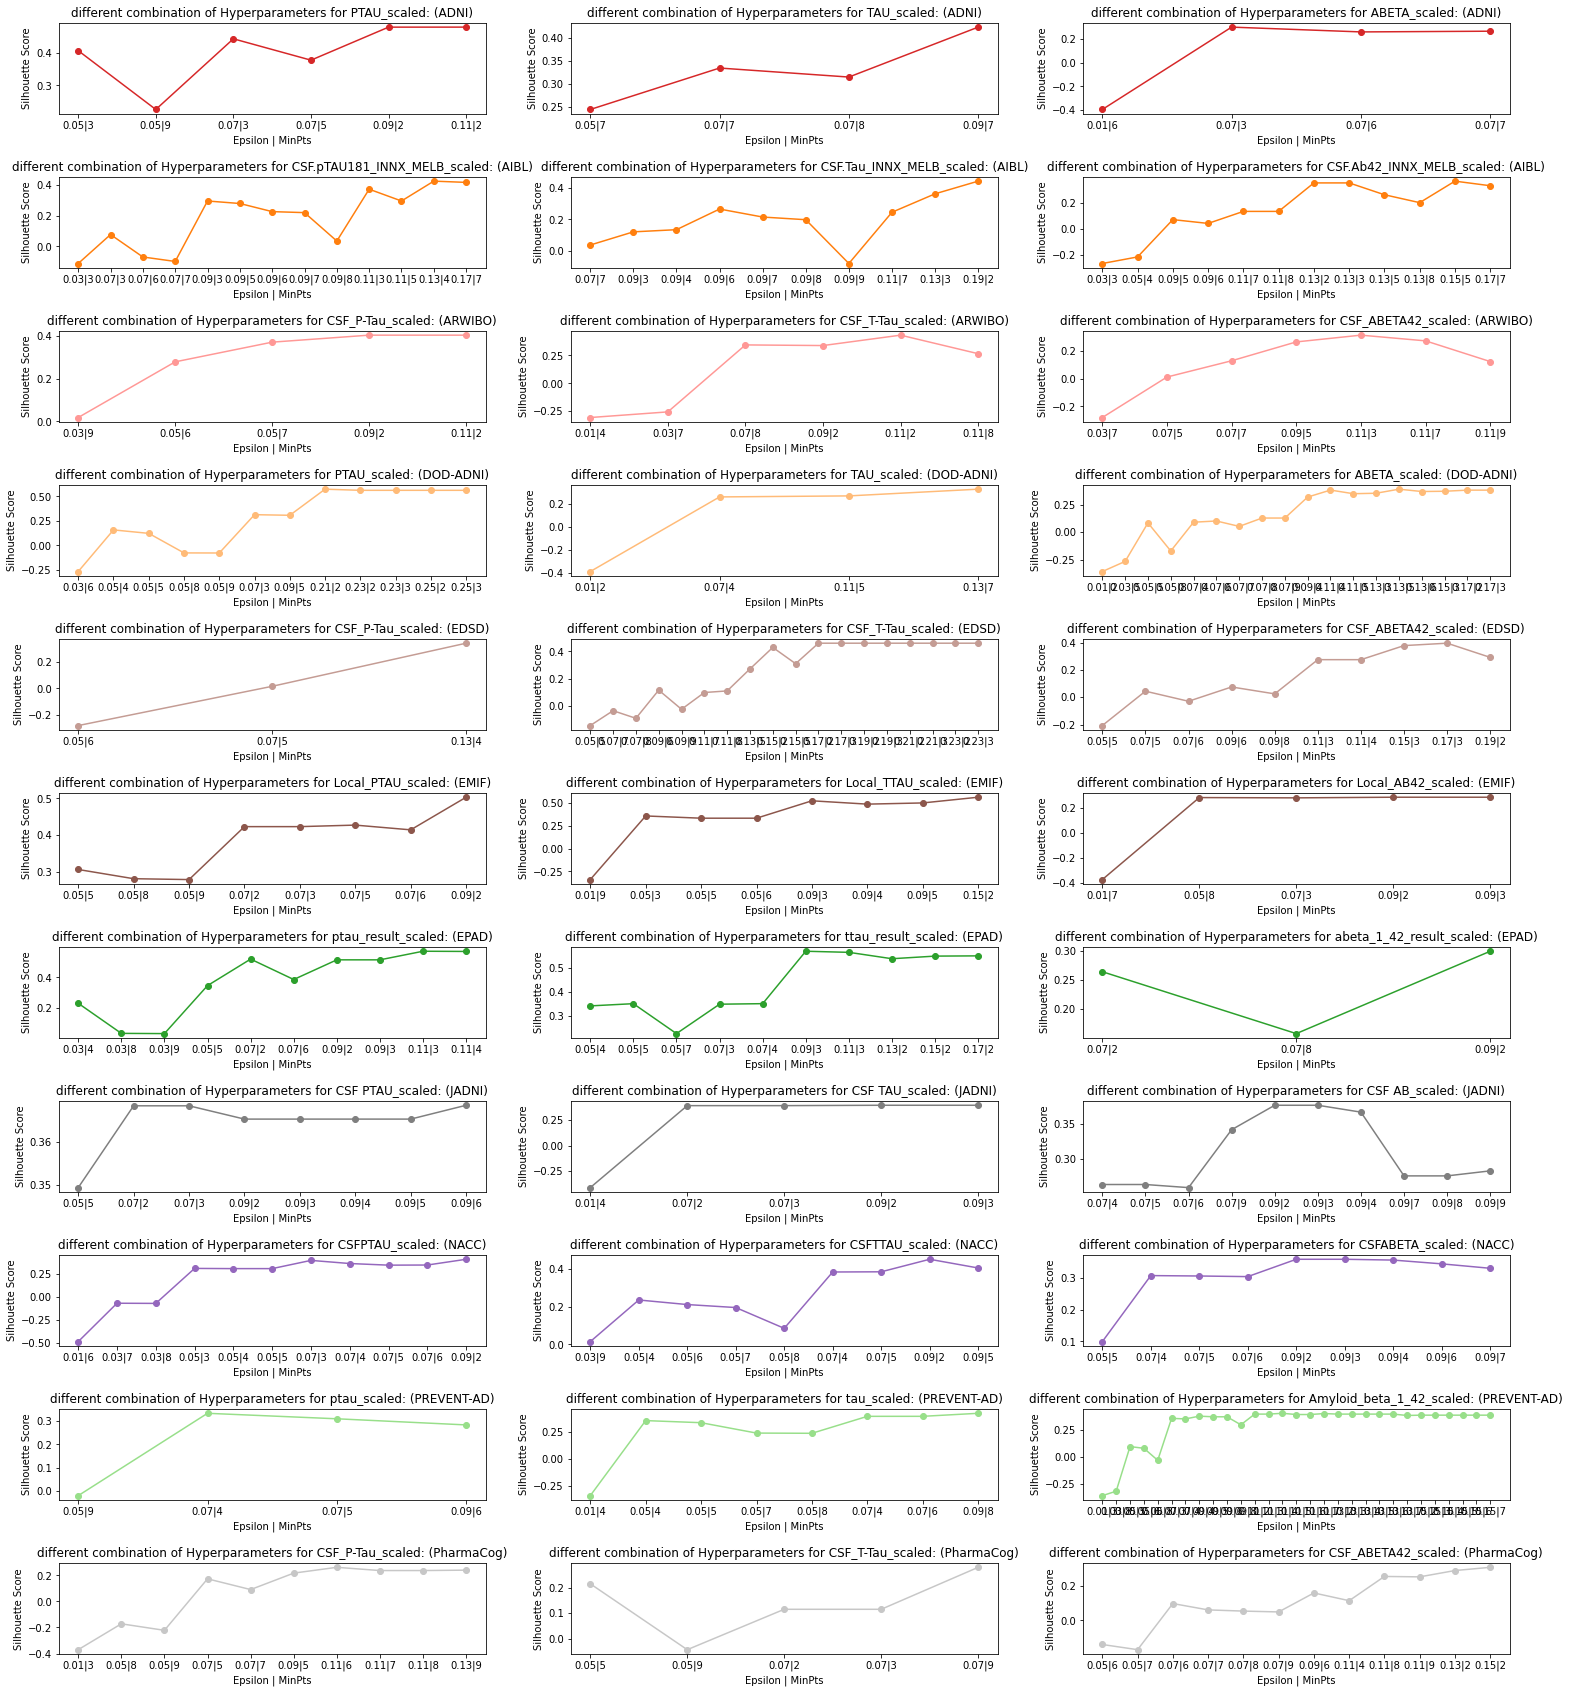

In [31]:
colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}

fig, axes = plt.subplots(11, 3, sharex=False, figsize=(26, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting Silhouette scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], scoresss[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Epsilon | MinPts')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('Silhouette Score')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'different combination of Hyperparameters for {i}: ({cohort})')
    ind+=1

In [32]:
# for i in scoresss['ADNI']:
#     print(np.max(scoresss['ADNI'][i]))
#     maxx = np.max(scoresss['ADNI'][i])
#     print(scoresss['ADNI'][i].index(maxx))

### Save all Silhouette scores and hyperparameters into dataframes for each cohort

In [33]:
score_hyper_dfs = dict()

for i in scoresss:
    for bio in scoresss[i]:
        score_df = pd.DataFrame.from_dict(scoresss[i], orient='index').transpose()
        score_df.columns = [x + '_score' for x in  score_df.columns]
        hyper_df = pd.DataFrame.from_dict(hypersss[i], orient='index').transpose()
        hyper_df.columns = [x + '_hyper' for x in  hyper_df.columns]
        score_hyper_dfs[i] = pd.concat([score_df, hyper_df], axis=1)

In [34]:
score_hyper_dfs['ADNI']

,PTAU_scaled_score,TAU_scaled_score,ABETA_scaled_score,PTAU_scaled_hyper,TAU_scaled_hyper,ABETA_scaled_hyper
0,0.406022,0.245174,-0.395435,0.05|3,0.05|7,0.01|6
1,0.226230,0.334655,0.301423,0.05|9,0.07|7,0.07|3
2,0.442217,0.315188,0.260800,0.07|3,0.07|8,0.07|6
3,0.376941,0.422995,0.266887,0.07|5,0.09|7,0.07|7
4,0.477871,NaN,NaN,0.09|2,None,None
5,0.477952,NaN,NaN,0.11|2,None,None


In [35]:
for cname in score_hyper_dfs:
    
    for col in score_hyper_dfs[cname].columns:

        if '_score' in col:
#             print(col.strip('_score'), col.split('_score')[0] + '_hyper')
            hypers_ = col.split('_score')[0] + '_hyper' 
            e, n = score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.max(score_hyper_dfs[cname][col].dropna()), hypers_].iloc[0].split("|")
            print(cname, col, score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.max(score_hyper_dfs[cname][col].dropna()), hypers_].iloc[0].split("|"))
            # Set the model and its parameters
            model = DBSCAN(eps=float(e), min_samples=float(n))
            # Fit the model 
            clm = model.fit(cohorts_csf[cname][[col.split('_score')[0], 'Age_scaled']])
            cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN"] = clm.labels_

ADNI PTAU_scaled_score ['0.11', '2']
ADNI TAU_scaled_score ['0.09', '7']
ADNI ABETA_scaled_score ['0.07', '3']
AIBL CSF.pTAU181_INNX_MELB_scaled_score ['0.13', '4']
AIBL CSF.Tau_INNX_MELB_scaled_score ['0.19', '2']
AIBL CSF.Ab42_INNX_MELB_scaled_score ['0.15', '5']
ARWIBO CSF_P-Tau_scaled_score ['0.09', '2']
ARWIBO CSF_T-Tau_scaled_score ['0.11', '2']
ARWIBO CSF_ABETA42_scaled_score ['0.11', '3']
DOD-ADNI PTAU_scaled_score ['0.21', '2']
DOD-ADNI TAU_scaled_score ['0.13', '7']
DOD-ADNI ABETA_scaled_score ['0.13', '5']
EDSD CSF_P-Tau_scaled_score ['0.13', '4']
EDSD CSF_T-Tau_scaled_score ['0.17', '2']
EDSD CSF_ABETA42_scaled_score ['0.17', '3']
EMIF Local_PTAU_scaled_score ['0.09', '2']
EMIF Local_TTAU_scaled_score ['0.15', '2']
EMIF Local_AB42_scaled_score ['0.09', '2']
EPAD ptau_result_scaled_score ['0.11', '3']
EPAD ttau_result_scaled_score ['0.09', '3']
EPAD abeta_1_42_result_scaled_score ['0.09', '2']
JADNI CSF PTAU_scaled_score ['0.09', '6']
JADNI CSF TAU_scaled_score ['0.09', '2']

### plot all clusters for each biomarker in each cohort

In [36]:
Counter(cohorts_csf['ADNI']['PTAU_ATN'])

Counter({0: 1012, -1: 3, 1: 2})

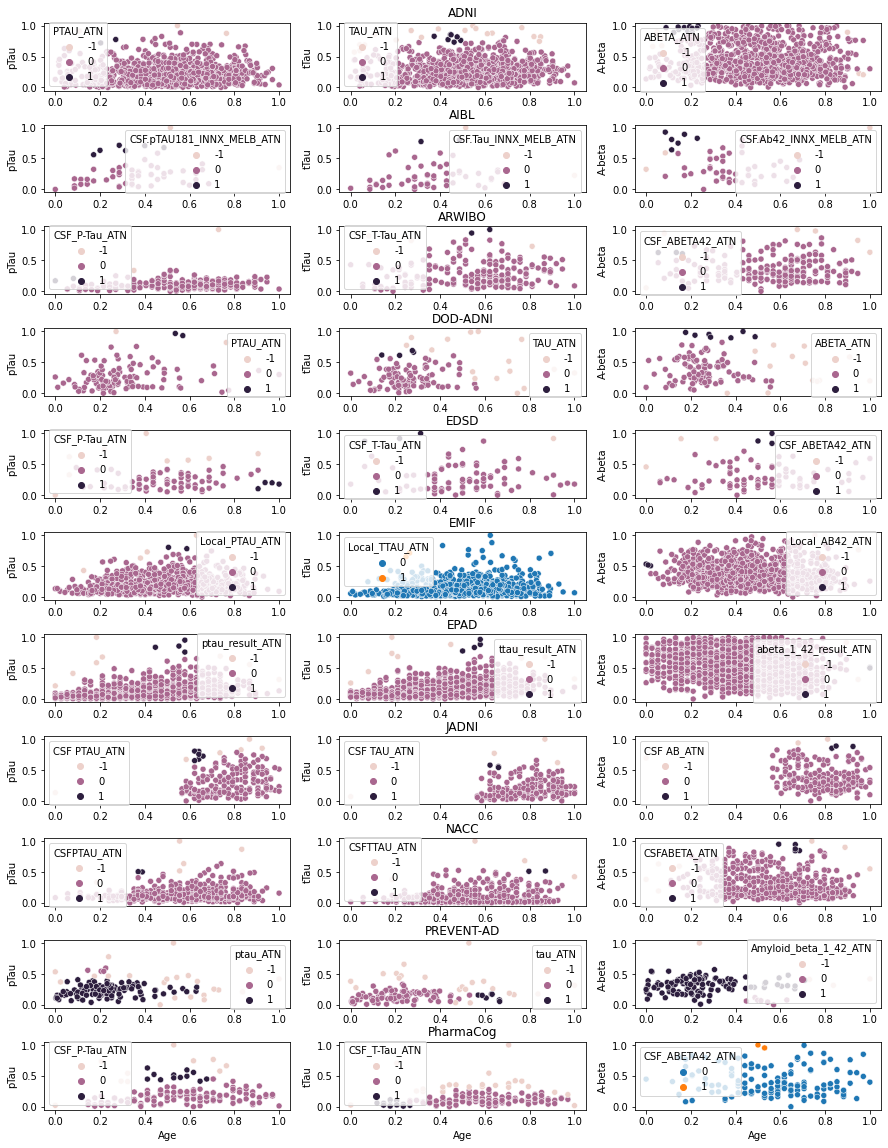

In [50]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)
i=0

for ind in cohorts_csf:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    feat_ = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, fea_  in zip(csf, feat_):
#         sns.scatterplot(x=cohorts_csf[ind]['Age_scaled'], y=cohorts_csf[ind][bioma + "_scaled"], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         sns.histplot(x=cohorts_csf[ind][bioma + "_scaled"], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
        sns.scatterplot(y=cohorts_csf[ind][bioma + "_scaled"], x=cohorts_csf[ind]["Age_scaled"], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
        axes[i, csf.index(bioma)].set(xlabel='')
        axes[i, csf.index(bioma)].set_ylabel(fea_.split(' ')[0], fontsize=10)
        axes[i, 1].set_title(ind, fontsize=12, pad=6)
        axes[10, csf.index(bioma)].set_xlabel('Age', fontsize=10)
    
    i+=1
    
plt.savefig("../results/csf_biomarkers_cluster.png", dpi=300, bbox_inches='tight')